**Porcentaje de población que consdidera que existen rutas insuficientes de transporte público**

In [1]:
#Limpiar la zona de trabajo
rm(list=ls())
#Librerias
if (require('pacman')) install.packages('pacman')
pacman::p_load(tidyverse,
               readr, 
               srvyr,
               ggplot2)


Cargando paquete requerido: pacman

Warning message:
"package 'pacman' is in use and will not be installed"


In [2]:
#Consideraciones----
#Tiempo en linea
options(timeout = 8000)
options(survey.lonely.psu = "certainty") 

In [3]:
#Función para leer los datos de ENCIG
leer_encig <- function(anio) { 
  # URLs de descarga
  urls <- list(
    "2017" = "https://www.inegi.org.mx/contenidos/programas/encig/2017/microdatos/encig17_base_datos_dbf.zip",
    "2019" = "https://www.inegi.org.mx/contenidos/programas/encig/2019/microdatos/encig19_base_datos_dbf.zip",
    "2021" = "https://www.inegi.org.mx/contenidos/programas/encig/2021/microdatos/encig21_base_datos_dbf.zip",
    "2023" = "https://www.inegi.org.mx/contenidos/programas/encig/2023/microdatos/encig23_base_datos_dbf.zip"
  )
  
  # Archivos temporales
  temp_zip <- tempfile(fileext = ".zip")
  temp_dir <- tempdir()
  
  # Descargar y descomprimir
  download.file(urls[[as.character(anio)]], temp_zip, mode = "wb")
  unzip(temp_zip, exdir = temp_dir)
  
  # Sufijo según el año
  sufijo <- if (anio %in% c(2017, 2019)) {
    "_3_4_5_8_9_10.dbf"
  } else {
    "_A_3_4_5_8_9_10.dbf"
  }
  
  # Nombre del archivo
  nombre_dbf <- file.path(temp_dir, paste0("encig", anio, "_01_sec1", sufijo))
  
  # Leer base
  datos <- foreign::read.dbf(nombre_dbf, as.is = TRUE)
  
  return(datos)
}



In [4]:
##función para crear variable dicotómica de rutas
creacion_de_variable <- function(anio) {
  
  objeto_datos <- get(paste0("encig", anio))
  
  mutate(objeto_datos, 
         rutas = ifelse(P5_9_5 %in% c("1","2") & P5_10_5 %in% c("1","2"), "Con respuesta","Sin respuesta"))|>
  filter(rutas == "Con respuesta")|>
  mutate(satis_rutas = ifelse(P5_9_5 == "1" & P5_10_5 == "1", "Rutas suficientes", "Rutas insuficientes"), 
         FAC_P18= as.numeric(FAC_P18), 
         año = anio)

}

In [5]:
#Función para definir el diseño muestral
diseño_muestral <- function(anio) {
  
  objeto_datos <- get(paste0("encig", anio))
  
  as_survey_design(objeto_datos,
                   strata = EST_DIS,
                   weights = FAC_P18,
                   ids = UPM_DIS,
                   nest = TRUE)
}

In [6]:
#Obtener porcentajes y totales con coeficiente de variación
resultados <- function(anio) 
  {
  datos <- get(paste0("s_rut", anio))
  
  datos_dm <- datos |>
    group_by(satis_rutas) |>
    summarise(tot_p_rutas = survey_total(vartype = "cv"),
              porcentaje = survey_prop(vartype = "cv") * 100)|>
    filter(satis_rutas == "Rutas insuficientes")|>
    select(satis_rutas, tot_p_rutas, porcentaje, porcentaje_cv)
  
  return(datos_dm)
}

In [7]:
encig2017 <- leer_encig(2017)|>
  filter(ENT == "09")
encig2019 <- leer_encig(2019)|>
  filter(ENT == "09")
encig2021 <- leer_encig(2021)|>
  filter(ENT == "09")
encig2023 <- leer_encig(2023)|>
  filter(CVE_ENT == "09")

In [8]:
encig2017<-creacion_de_variable(2017)
encig2019<-creacion_de_variable(2019)
encig2021<-creacion_de_variable(2021)
encig2023<-creacion_de_variable(2023)

In [9]:
s_rut2017<-diseño_muestral(2017)
s_rut2019<-diseño_muestral(2019)
s_rut2021<-diseño_muestral(2021)
s_rut2023<-diseño_muestral(2023)

In [10]:
rutas_2017<-resultados(2017)|>
  mutate(anio = 2017)
rutas_2019<-resultados(2019)|>
  mutate(anio = 2019)
rutas_2021<-resultados(2021)|>
  mutate(anio = 2021)
rutas_2023<-resultados(2023)|>
  mutate(anio = 2023)

In [11]:
rutastot<-rutas_2017|>
  bind_rows(rutas_2023, rutas_2019, rutas_2021)|>
  arrange(anio)

rutastot

rutastot<-rutastot|>
  select(porcentaje, anio)|>
  mutate(tipo = "Observado")

satis_rutas,tot_p_rutas,porcentaje,porcentaje_cv,anio
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Rutas insuficientes,1819829,72.81859,1.751930,2017
Rutas insuficientes,2128141,67.77856,1.733339,2019
Rutas insuficientes,1763601,63.64229,2.039425,2021
Rutas insuficientes,1163727,33.20131,3.628379,2023


In [12]:
rutastot_2023 <- rutastot |> filter(anio == 2023)
rutastot_2017 <- rutastot |> filter(anio == 2017)

In [17]:
##ESCENARIOS TENDENCIALES 2030,2035,2045
# Tasa de variación
tcma<-((rutastot_2023$porcentaje /rutastot_2017$porcentaje)^(1/(2023-2017)) - 1) 
tcma

rutastot_base <- rutastot |>
  filter(anio == 2023) |>
  pull(porcentaje)

rutastot_base

# Años a proyectar
años <- c(2030,2035,2045)
año_base <- 2023

tendencia_base <- data.frame(anio = años,
                             porcentaje = round(rutastot_base * (1 + 1/4*tcma) ^ (años - año_base), 2),
                             tipo = "Inercial")


tendecia_deseable<-data.frame(anio = años,
                              porcentaje = round(rutastot_base * (1 + 1/2*tcma) ^ (años - año_base), 2),
                              tipo = "Deseable")


tendecia_transformadora <-data.frame(anio = años,
                                     porcentaje = round(rutastot_base * (1 + 3/4*tcma) ^ (años - año_base), 2),
                                     tipo = "Transformador")

rutastot_tendencias <- rutastot|>
  bind_rows(tendencia_base,tendecia_deseable, 
            tendecia_transformadora)|>
  select(anio, porcentaje, tipo)

rutastot_tendencias


[1] -0.1226918

[1] 33.20131

anio,porcentaje,tipo
<dbl>,<dbl>,<chr>
2017,72.81859,Observado
2019,67.77856,Observado
2021,63.64229,Observado
2023,33.20131,Observado
2030,26.70000,Inercial
2035,22.85000,Inercial
2045,16.73000,Inercial
2030,21.32000,Deseable
2035,15.53000,Deseable


In [18]:

lineas <- bind_rows(data.frame(anio = c(2023, 2030),
                               porcentaje = c(rutastot_tendencias$porcentaje[rutastot_tendencias$anio == 2023 & rutastot_tendencias$tipo == "Observado"],
                                              rutastot_tendencias$porcentaje[rutastot_tendencias$anio == 2030 & rutastot_tendencias$tipo == "Inercial"]),
                               tipo = "Inercial"),
                    data.frame(anio = c(2023, 2030),
                               porcentaje = c(rutastot_tendencias$porcentaje[rutastot_tendencias$anio == 2023 & rutastot_tendencias$tipo == "Observado"], 
                                              rutastot_tendencias$porcentaje[rutastot_tendencias$anio == 2030 & rutastot_tendencias$tipo == "Deseable"]),
                               tipo = "Deseable"), 
                    data.frame(anio = c(2023, 2030),
                               porcentaje = c(rutastot_tendencias$porcentaje[rutastot_tendencias$anio == 2023 & rutastot_tendencias$tipo == "Observado"], 
                                              rutastot_tendencias$porcentaje[rutastot_tendencias$anio == 2030 & rutastot_tendencias$tipo == "Transformador"]),
                               tipo = "Transformador"))


paleta_colores <- c("Observado" = "#9F2241",
                    "Inercial" = "#cfcfcf" ,
                    "Deseable" = "#027A35", 
                    "Transformador" = "#AC6D14")

linetypes <- c("Observado" = "solid",
               "Inercial" = "dotdash",
               "Deseable" = "dotdash", 
               "Transformador" = "dotdash")



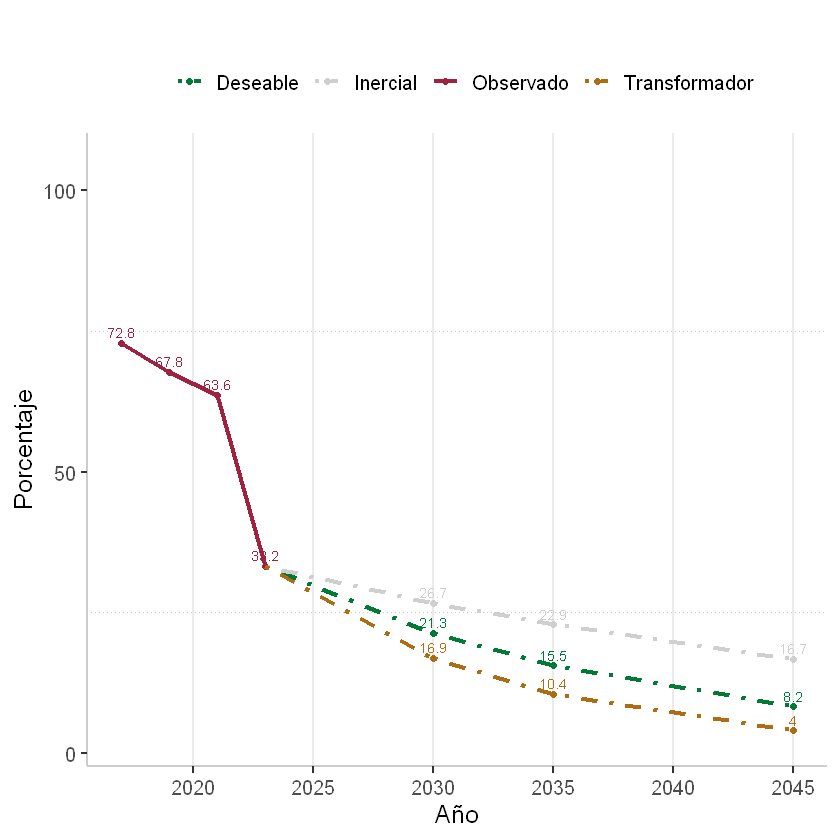

In [19]:

# Gráfico con etiquetas y eje Y personalizado
ggplot(rutastot_tendencias, aes(x = anio, y = porcentaje, group = tipo, color = tipo, linetype = tipo)) +
  geom_line(linewidth = 1.2) +
  geom_point(size = 1.5) +
  geom_line(data = lineas, aes(x = anio, y = porcentaje, group = tipo), linewidth = 1.2) +
  geom_text(aes(label = round(porcentaje, 1)),
            position = position_nudge(y = 2),
            size = 3, show.legend = FALSE) +
  scale_color_manual(values = paleta_colores) +
  scale_linetype_manual(values = linetypes) +
  scale_y_continuous(breaks = seq(0, max(rutastot_tendencias$porcentaje, na.rm = TRUE) +100, by = 50),
                     labels = function(x) paste0(x, ""),
                     expand = expansion(mult = c(0.09,0.5))) +
  labs(title = "",
       x = "Año",
       y = "Porcentaje",
       color = "",
       linetype = "") +
  theme_bw(base_size = 15) +
  theme( panel.grid.minor.y = element_line(color = "gray80", linetype = "dotted"),
         panel.grid.minor.x = element_blank(),
         panel.grid.major.y = element_blank(),
         panel.border = element_blank(),
         axis.line = element_line(color = "gray80"),
         legend.position = "top",
         plot.caption = element_text(hjust = 100))

#ggsave("rutastot_tendencias.png", width = 8, height = 5, dpi = 300)